# Setup

In [1]:
# #%% Setup.

# Navigate to the directory you would like to use for this demo.
# Note: when ardent is ready for a stable release it will be uploaded to PyPI and be directly pip installable.

# Clone ardent into that directory.
# ! git clone https://github.com/neurodata/ardent.git

# pip install ardent. Use -e to create a symlink in case you want to make edits to ardent yourself.
# ! pip3 install -e ardent

## Imports

In [2]:
#%% Imports.

import numpy as np
import ardent
import torch
import matplotlib
%matplotlib inline

/home/dcrowley/env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Prepare template and target

### Load template and target arrays from file.

Note: in this demo we use the Allen mouse brain atlas for the template, and thus the words 'atlas' and 'template' are effectively interchangable hereafter.

'atlas' is used in the code of this demo, whereas 'template' is used internally to ardent.

In [3]:
#%% Load template and target.
# Using this data from the ARDENT package expects that you have cloned the ARDENT repo rather than just downloading this demo.ipynb file.
# If you have your own data, feel free to pull it in by file name, or use numpy arrays directly in the Transform.register call.

directory_path = './demo_data/'
atlas_image_file_name = 'average_template_100.nrrd'
target_image_file_name = 'thy1eyfp_preprocessed_100um.vtk'

atlas_file_name = directory_path + atlas_image_file_name
target_file_name = directory_path + target_image_file_name

atlas = ardent.load(atlas_file_name)
target = ardent.load(target_file_name)

atlas = atlas.astype(float)
target = target.astype(float)

### Preprocess template and target 

In [4]:
#%% Reform and normalize images.

atlas = ardent.basic_preprocessing(atlas)
target = ardent.basic_preprocessing(target)

# If you are wondering, the above does the same thing as below:
'''
# Cast as np.ndarray of type dtype.

atlas = np.array(atlas, dtype=float)
target = np.array(target, dtype=float)

# Pad with zeros.

atlas = np.pad(atlas, pad_width=5, mode='constant', constant_values=0)
target = np.pad(target, pad_width=5, mode='constant', constant_values=0)

# Normalize.

# Compute mean absolute deviation.
atlas_mean_absolute_deviation = np.mean(np.abs(atlas - np.median(atlas)))
target_mean_absolute_deviation = np.mean(np.abs(target - np.median(target)))

# Subtract the mean.
atlas -= np.mean(atlas)
target -= np.mean(target)

# Divide by mean absolute deviation.
atlas /= atlas_mean_absolute_deviation
target /= target_mean_absolute_deviation
''';

## Orient target to template

### Visualize images

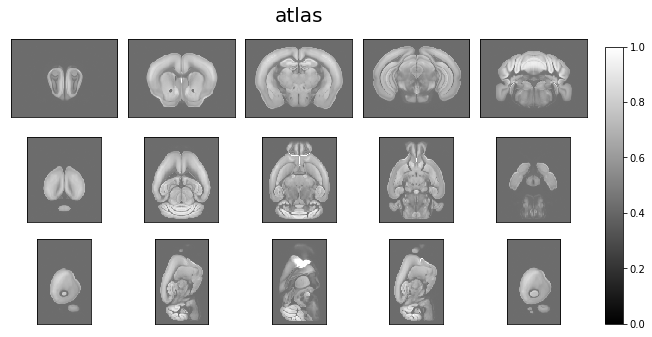

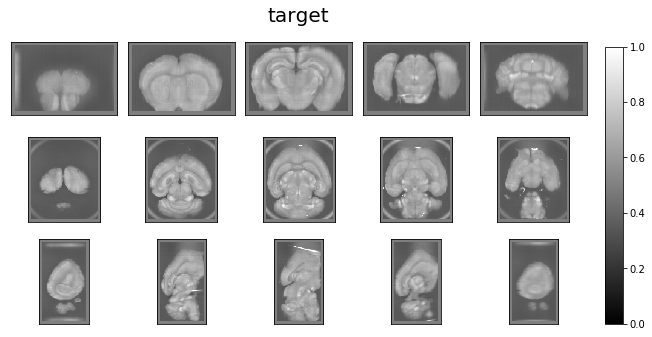

In [5]:
#%% Visualize images before registration.
# It is important to check that the images are oriented to one another 
# and do not require rotating or flipping.

ardent.heatslices(atlas, title='atlas', limit_mode='stdev')
ardent.heatslices(target, title='target', limit_mode='stdev')

### Reorient target and revisualize

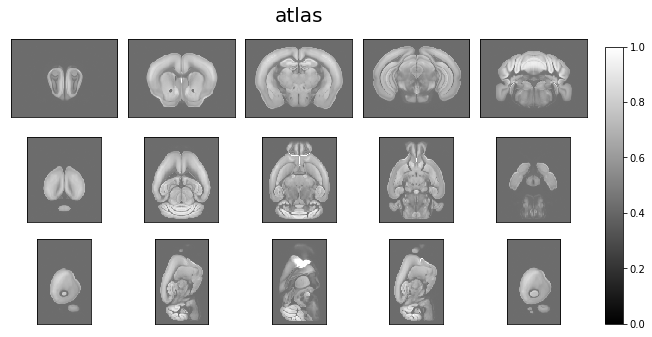

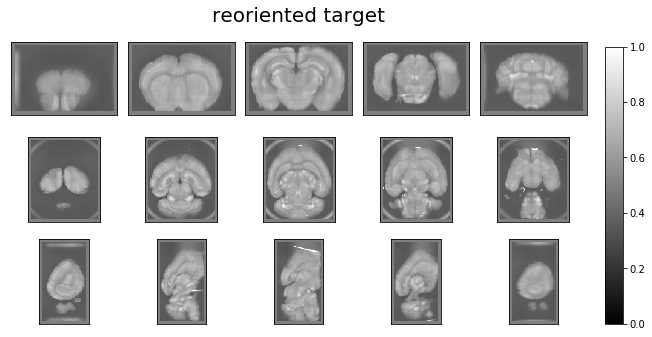

In [6]:
#%% Orient images.
# From looking at the two images we can see that they are not oriented.
# This must be corrected prior to performing the registration.

# Here we will orient the target to the template (atlas).
reoriented_target = np.copy(target)

# For the data in this demo the images are already oriented, 
# but otherwise they can be oriented with some combination of the following functions.

# reoriented_target = np.moveaxis(reoriented_target, source=[0,1,2], destination=[0,1,2])
# reoriented_target = np.rot90(reoriented_target, axes=(0,1))
# reoriented_target = np.flip(reoriented_target, axis=0)

# If we performed an odd number of inversions with the above lines, 
# we must perform a flip to correct for inverting the image. 
# The simplest flip is a sagittal flip, since that is the axis of innate symmetry in the brain.
# In this case, we can see from the atlas visualization that this is axis 2 (the last row).

# reoriented_target = np.flip(reoriented_target, axis=2)

# Verify proper orientation.
ardent.heatslices(atlas, title='atlas', limit_mode='stdev')
ardent.heatslices(reoriented_target, title='reoriented target', limit_mode='stdev')

### Use reoriented target

In [7]:
#%% Use reoriented target.
# Once we've finished orienting target, we use the result as target.
target = reoriented_target

# Perform registration

In [8]:
#%% Perform registration.
# The empty_cache function allows the register method to be run multiple times without overflowing the GPU memory.
torch.cuda.empty_cache()

# Instantiate Transform object.
transform = ardent.Transform()

# The default is naffine=50 affine-only iterations and niter=200 total iterations.
# This should take approximately 1 minute.
transform.register(template=atlas, target=target, preset='clarity, mouse')

Completed iteration 0, E=730825.7762460298, EM=730825.7762460298, ER=0.0
Completed iteration 10, E=575497.9781920103, EM=575497.9781920103, ER=0.0
Completed iteration 20, E=547812.8136607732, EM=547812.8136607732, ER=0.0
Completed iteration 30, E=538701.8475350032, EM=538701.8475350032, ER=0.0
Completed iteration 40, E=536445.3085349337, EM=536445.3085349337, ER=0.0
Completed iteration 50, E=536011.625226777, EM=536011.625226777, ER=0.0
Completed iteration 60, E=497013.1283536061, EM=496776.237347666, ER=236.89100594012308
Completed iteration 70, E=469969.0363208084, EM=469182.56100280327, ER=786.4753180051284
Completed iteration 80, E=480677.37810576096, EM=479227.2443296658, ER=1450.1337760951837
Completed iteration 90, E=477422.44115761184, EM=475379.196377501, ER=2043.2447801108115
Completed iteration 100, E=470320.8554060589, EM=467678.15726058686, ER=2642.698145472057
Completed iteration 110, E=464304.6035072609, EM=461067.26884614845, ER=3237.3346611124775
Completed iteration 12

# Apply transformation

In [9]:
#%% Make an output directory. Feel free to choose a different location for your outputs.
from pathlib import Path

output_directory_path = './demo_outputs/'

output_directory_Path = Path(output_directory_path).expanduser().resolve()
output_directory_Path.mkdir(exist_ok=True)

In [10]:
#%% Apply the transformation.
# The transformation is the result of the registration, and it can be applied to arbitrary images, 
# although presently they should be preprocessed as the atlas and target were.
# Here we will simply apply the transformation to both the atlas and target, 
# making them match up with each other.
# i.e. deformed_target should resemble atlas, and deformed_atlas should resemble target.

deformed_atlas_file_name = output_directory_path + 'deformed_atlas'
deformed_target_file_name = output_directory_path + 'deformed_target'

deformed_atlas = transform.apply_transform(subject=atlas, deform_to='target', save_path=deformed_atlas_file_name)
deformed_target = transform.apply_transform(subject=target, deform_to='template')

ardent.save(deformed_target, deformed_target_file_name)

# Note: deformed_atlas is saved in the apply_transform call by providing a path for save_path.
# Note: deformed_target is saved after-the-fact with ardent.save(data, file_path).
# They can be read in with ardent.load('deformed_atlas') and ardent.load('deformed_target')

# Visualize results

### After Registration

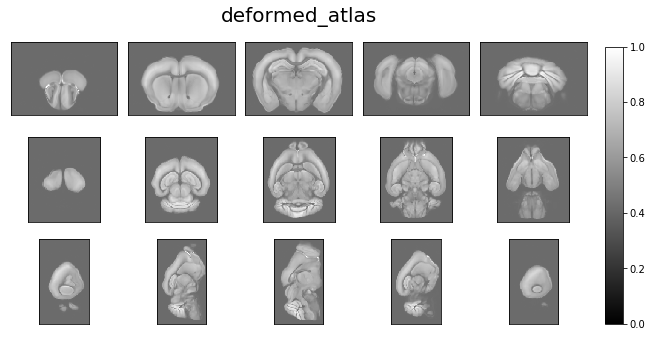

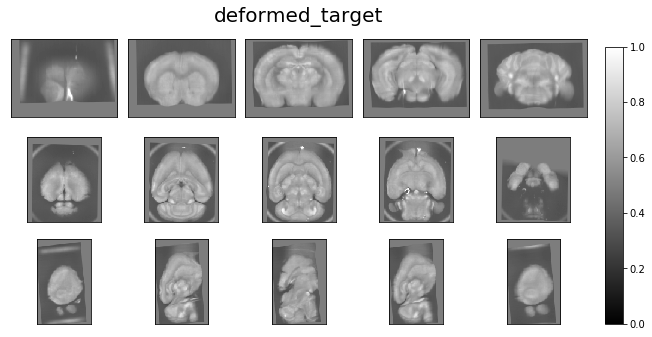

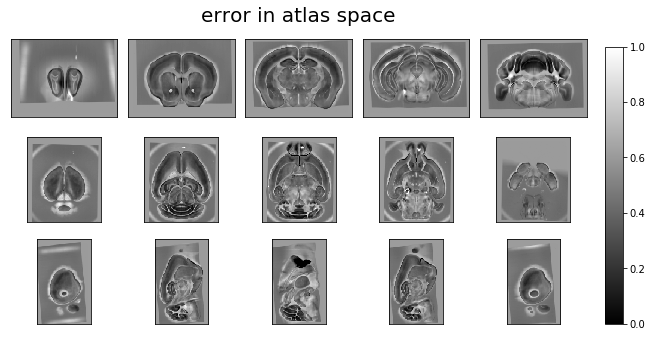

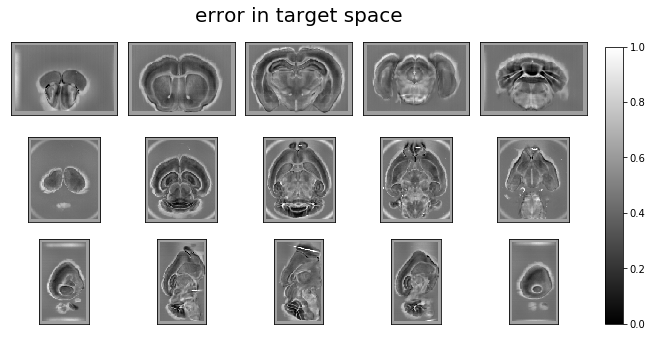

In [11]:
#%% Visualize results.

ardent.heatslices(deformed_atlas, title='deformed_atlas', limit_mode='stdev')
ardent.heatslices(deformed_target, title='deformed_target', limit_mode='stdev')

# To simply visualize error we plot the difference between images.
ardent.heatslices(deformed_target - atlas, title='error in atlas space', limit_mode='stdev')
ardent.heatslices(target - deformed_atlas, title='error in target space', limit_mode='stdev')

### Before Registration

In [12]:
# To visualize the error before registration we must first put the atlas and the target in the same space. 
# That is, we must make the atlas the same shape as the target or vice versa.

torch.cuda.empty_cache()
# Note: it is not necessary to create a new Transform object, but we are doing so here 
# to preserve the state of transform for the demonstration of Transform.save and Transform.load below.
identity_transform = ardent.Transform()
identity_transform.register(template=atlas, target=target, preset='identity')

atlas_in_target = identity_transform.apply_transform(subject=atlas, deform_to='target')
target_in_atlas = identity_transform.apply_transform(subject=target, deform_to='template')

Completed iteration 0, E=nan, EM=730825.7762460298, ER=nan


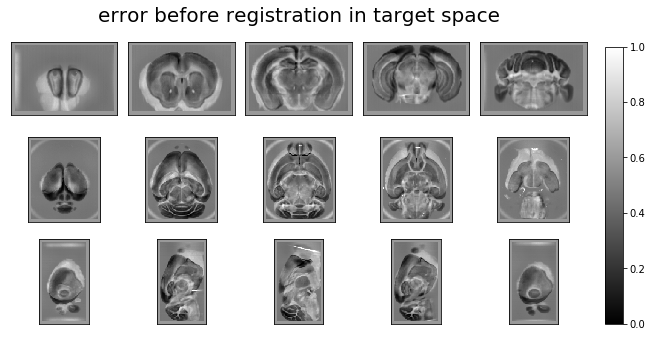

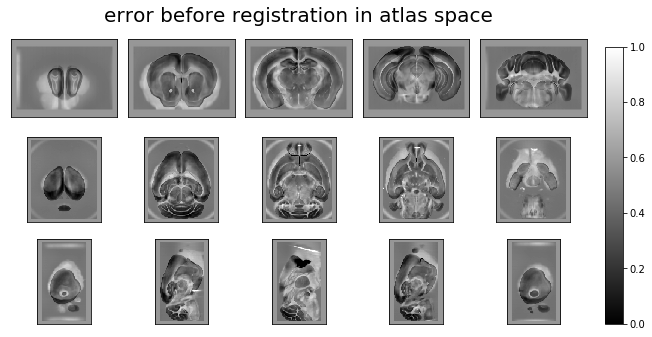

In [13]:
ardent.heatslices(target - atlas_in_target, title='error before registration in target space', limit_mode='stdev')
ardent.heatslices(target_in_atlas - atlas, title='error before registration in atlas space', limit_mode='stdev')

### In Color

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

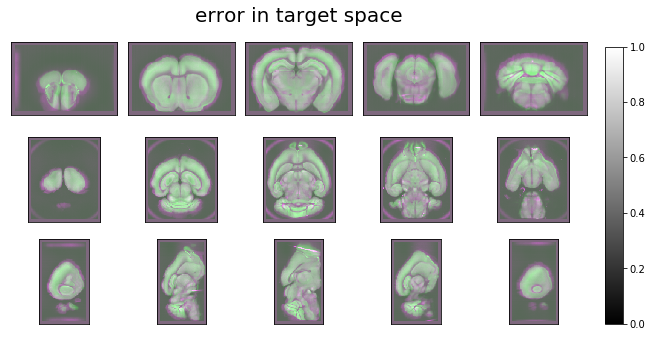

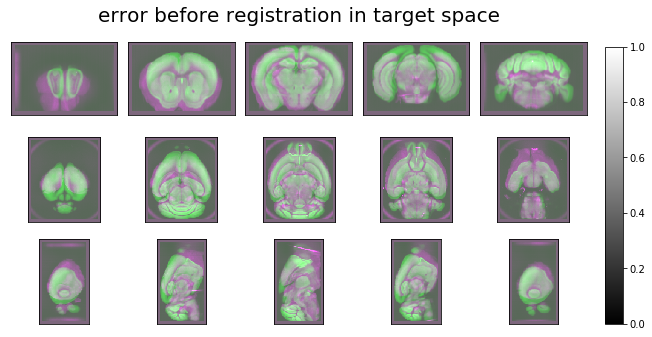

In [14]:
# It is often illuminating to see the errors as color overlays rather than differences.

# If you pass np.stack([image1, image2, image3], axis=-1) to ardent.heatslices instead of just one image, 
# it will interpret them as RGB channels, i.e. [red_channel, green_channel, blue_channel].

# Thus, to display for example the target in purple (red + blue), the atlas in green, and overlap in white (red + blue + green), 
# we can pass in np.stack([target, deformed_atlas, target], axis=-1).

# If you want to use only 2 of [red, green, blue], you should use np.zeros_like(image) in that channel.

ardent.heatslices(np.stack([target, deformed_atlas, target], axis=-1), title='error in target space', limit_mode='stdev')
ardent.heatslices(np.stack([target, atlas_in_target, target], axis=-1), title='error before registration in target space', limit_mode='stdev')

# Save the registration

In [15]:
transform_file_name = output_directory_path + 'transform'

transform.save(transform_file_name)

# Load the registration

In [16]:
# Make a new Transform object.
loaded_transform = ardent.Transform()

# Load the attributes from the saved transform
loaded_transform.load(transform_file_name)

# Pick up right where you left off.
loaded_deformed_atlas = loaded_transform.apply_transform(subject=atlas, deform_to='target')
loaded_deformed_target = loaded_transform.apply_transform(subject=target, deform_to='template')

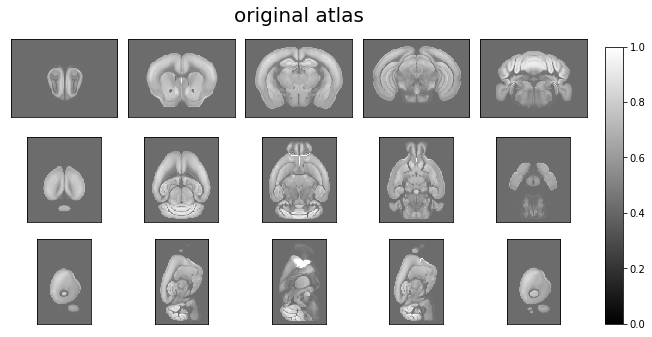

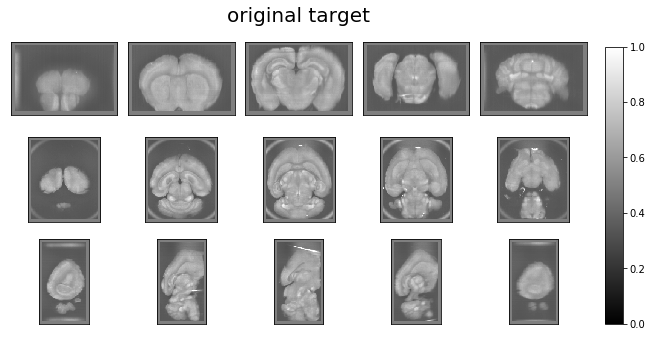

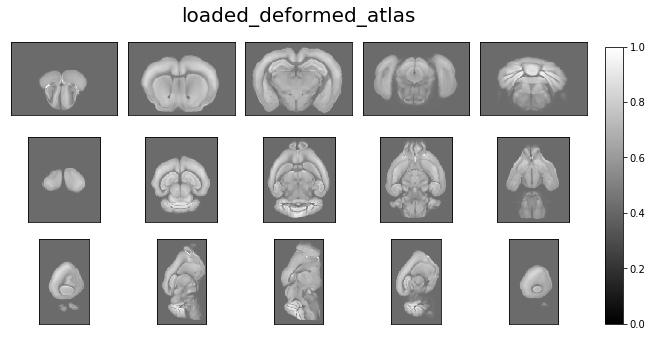

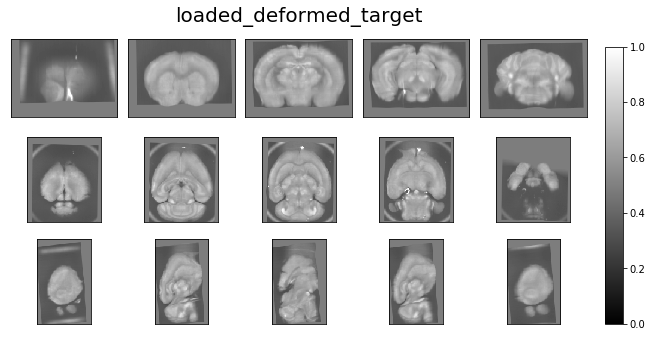

In [17]:
# See what the results are, compared to the original atlas and target.
ardent.heatslices(atlas, title='original atlas', limit_mode='stdev')
ardent.heatslices(target, title='original target', limit_mode='stdev')

ardent.heatslices(loaded_deformed_atlas, title='loaded_deformed_atlas', limit_mode='stdev')
ardent.heatslices(loaded_deformed_target, title='loaded_deformed_target', limit_mode='stdev')

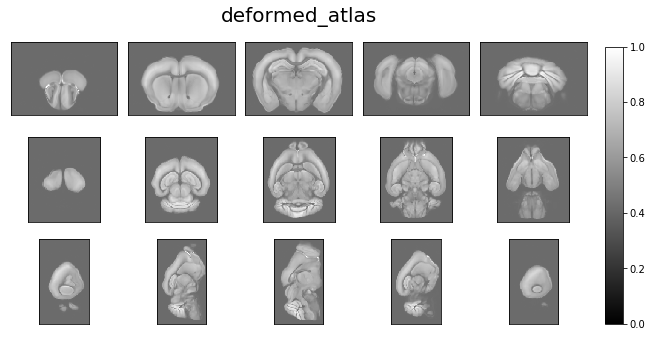

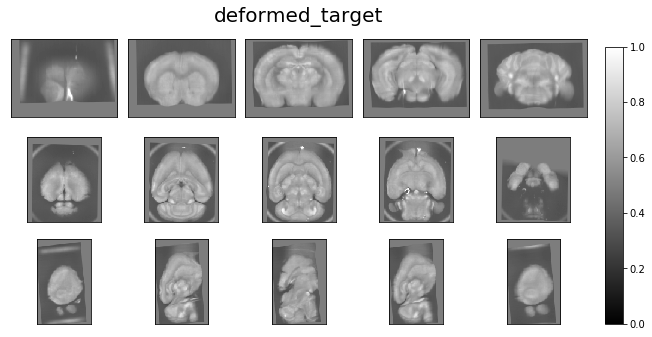

In [18]:
# Now compare with deformed_atlas and deformed_target from the transform object from before that did a full registration.
ardent.heatslices(deformed_atlas, title='deformed_atlas', limit_mode='stdev')
ardent.heatslices(deformed_target, title='deformed_target', limit_mode='stdev')